In [49]:
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
else:
    print("Go Ahead")

Go Ahead


In [50]:
import tensorflow_datasets as tfds

In [51]:
dataset, info = tfds.load('beans', as_supervised=True, with_info=True)

In [52]:
print(info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='C:\\Users\\abdel\\tensorflow_datasets\\beans\\0.1.0',
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo 

In [53]:
class_names = info.features['label'].names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [54]:
num_classes = info.features['label'].num_classes
num_classes

3

In [55]:
info.splits

{'train': <SplitInfo num_examples=1034, num_shards=2>,
 'validation': <SplitInfo num_examples=133, num_shards=1>,
 'test': <SplitInfo num_examples=128, num_shards=1>}

In [56]:
dataset_size = info.splits["train"].num_examples
dataset_size

1034

In [57]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'beans',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

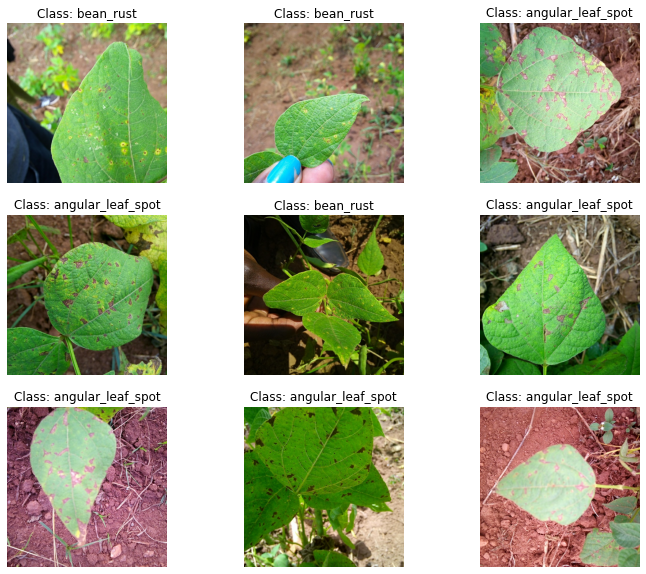

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_datasets.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")


In [17]:
IMG_SIZE = 250

def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    #final_image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

@tf.function
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size.
    image = tf.image.stateless_random_crop(
        image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness.
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [18]:
train_ds = train_datasets.shuffle(1000).repeat()
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_ds, (counter, counter)))


In [19]:
AUTOTUNE = tf.data.AUTOTUNE
AUTOTUNE

-1

In [21]:
batch_size=32

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment)
    .batch(batch_size)
    .prefetch(1)
)
train_ds

<PrefetchDataset shapes: ((None, 250, 250, 3), (None,)), types: (tf.float32, tf.int64)>

In [22]:
val_ds = (
    val_ds
    .map(resize_and_rescale)
    .batch(batch_size)
    .prefetch(1)
)
val_ds

<PrefetchDataset shapes: ((None, 250, 250, 3), (None,)), types: (tf.float32, tf.int64)>

In [23]:
test_ds = (
    test_ds
    .map(resize_and_rescale)
    .batch(batch_size)
    .prefetch(1)
)

In [24]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras import Sequential

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes)
    ])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
es = tf.keras.callbacks.EarlyStopping(patience=5)

history = model.fit(train_ds, epochs=40, batch_size=batch_size,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=val_ds,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks=es
                   )

Epoch 1/40
24/24 [==============================] - 7s 108ms/step - loss: 1.0578 - accuracy: 0.4466 - val_loss: 0.8696 - val_accuracy: 0.6154
Epoch 2/40
24/24 [==============================] - 2s 92ms/step - loss: 0.8999 - accuracy: 0.5964 - val_loss: 0.7039 - val_accuracy: 0.7500
Epoch 3/40
24/24 [==============================] - 2s 94ms/step - loss: 0.8067 - accuracy: 0.6380 - val_loss: 0.7084 - val_accuracy: 0.6538
Epoch 4/40
24/24 [==============================] - 2s 97ms/step - loss: 0.8283 - accuracy: 0.5911 - val_loss: 0.6955 - val_accuracy: 0.7596
Epoch 5/40
24/24 [==============================] - 2s 93ms/step - loss: 0.7106 - accuracy: 0.6940 - val_loss: 0.6323 - val_accuracy: 0.7692
Epoch 6/40
24/24 [==============================] - 2s 94ms/step - loss: 0.7246 - accuracy: 0.6771 - val_loss: 0.6543 - val_accuracy: 0.7404
Epoch 7/40
24/24 [==============================] - 2s 94ms/step - loss: 0.6360 - accuracy: 0.7044 - val_loss: 0.6110 - val_accuracy: 0.7308
Epoch 8/40
2

In [29]:
model.evaluate(test_ds)

4/4 [==============================] - 0s 70ms/step - loss: 0.4846 - accuracy: 0.8447


[0.4845502972602844, 0.844660222530365]

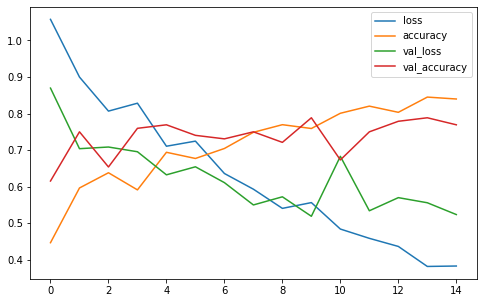

In [30]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [58]:
def resize_and_rescale(image, label):
    IMG_SIZE = 250
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    final_image = tf.keras.applications.mobilenet.preprocess_input(image)
    return final_image, label

def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size.
    image = tf.image.stateless_random_crop(
        image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness.
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [59]:
train_ds = train_datasets.shuffle(1000).repeat()
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_ds, (counter, counter)))

In [60]:
batch_size=32

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment)
    .batch(batch_size)
    .prefetch(1)
)

train_ds

<PrefetchDataset shapes: ((None, 250, 250, 3), (None,)), types: (tf.float32, tf.int64)>

In [61]:
val_ds = (
    val_ds
    .map(resize_and_rescale)
    .batch(batch_size)
    .prefetch(1)
)
val_ds

<PrefetchDataset shapes: ((None, 250, 250, 3), (None,)), types: (tf.float32, tf.int64)>

In [62]:

test_ds = (
    test_ds
    .map(resize_and_rescale)
    .batch(batch_size)
    .prefetch(1)
)
test_ds

<PrefetchDataset shapes: ((None, 250, 250, 3), (None,)), types: (tf.float32, tf.int64)>

In [63]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [64]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

In [81]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

In [82]:
new_model = Model(inputs=base_model.input, outputs=predictions)

In [83]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [84]:
for layer in base_model.layers:
    layer.trainable = False

In [85]:
new_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [86]:
es = tf.keras.callbacks.EarlyStopping(patience=5)

history2 = new_model.fit(train_ds, epochs=40, batch_size=batch_size,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=val_ds,
                    validation_steps=int(0.15 * dataset_size / batch_size),)

Epoch 1/40
24/24 [==============================] - 7s 164ms/step - loss: 0.9894 - accuracy: 0.8346 - val_loss: 0.8877 - val_accuracy: 0.9231
Epoch 2/40
24/24 [==============================] - 3s 108ms/step - loss: 0.3695 - accuracy: 0.9258 - val_loss: 0.4740 - val_accuracy: 0.9519
Epoch 3/40
24/24 [==============================] - 2s 101ms/step - loss: 0.1595 - accuracy: 0.9466 - val_loss: 0.3771 - val_accuracy: 0.9423
Epoch 4/40
24/24 [==============================] - 2s 104ms/step - loss: 0.1375 - accuracy: 0.9583 - val_loss: 0.2693 - val_accuracy: 0.9423
Epoch 5/40
24/24 [==============================] - 2s 100ms/step - loss: 0.1308 - accuracy: 0.9466 - val_loss: 0.2567 - val_accuracy: 0.9423
Epoch 6/40
24/24 [==============================] - 2s 99ms/step - loss: 0.1271 - accuracy: 0.9570 - val_loss: 0.2876 - val_accuracy: 0.9423
Epoch 7/40
24/24 [==============================] - 2s 99ms/step - loss: 0.1517 - accuracy: 0.9427 - val_loss: 0.5462 - val_accuracy: 0.9135
Epoch 8/

In [87]:
new_model.evaluate(test_ds)

4/4 [==============================] - 0s 55ms/step - loss: 0.2485 - accuracy: 0.9612


[0.24852989614009857, 0.9611650705337524]

In [88]:
for layer in base_model.layers:
    layer.trainable = True
    
new_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])   

history3 = new_model.fit(train_ds, epochs=40,                     
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=val_ds,
                    validation_steps=int(0.15 * dataset_size / batch_size),)

Epoch 1/40
24/24 [==============================] - 15s 397ms/step - loss: 0.2785 - accuracy: 0.9206 - val_loss: 14.1381 - val_accuracy: 0.3750
Epoch 2/40
24/24 [==============================] - 9s 359ms/step - loss: 0.3012 - accuracy: 0.9049 - val_loss: 9.3300 - val_accuracy: 0.4519
Epoch 3/40
24/24 [==============================] - 9s 365ms/step - loss: 0.2961 - accuracy: 0.9049 - val_loss: 11.3574 - val_accuracy: 0.3077
Epoch 4/40
24/24 [==============================] - 9s 364ms/step - loss: 0.2210 - accuracy: 0.9141 - val_loss: 8.7753 - val_accuracy: 0.3942
Epoch 5/40
24/24 [==============================] - 9s 361ms/step - loss: 0.2077 - accuracy: 0.9323 - val_loss: 12.4139 - val_accuracy: 0.3462
Epoch 6/40
24/24 [==============================] - 9s 370ms/step - loss: 0.2275 - accuracy: 0.9206 - val_loss: 1.3148 - val_accuracy: 0.8173
Epoch 7/40
24/24 [==============================] - 9s 377ms/step - loss: 0.1318 - accuracy: 0.9505 - val_loss: 10.2284 - val_accuracy: 0.4712
E

In [89]:
new_model.evaluate(test_ds)

4/4 [==============================] - 0s 60ms/step - loss: 3.8543 - accuracy: 0.6505


[3.8543295860290527, 0.6504854559898376]